라이브러리 import

In [3]:
import cv2
import numpy as np
from PIL import Image
from transparent_background import Remover
import matplotlib.pyplot as plt

광원 방향, 세기 함수 테스트 정의

(1542, 2048)
Dominant Light Direction (in degrees): 252.2477569580078, Magnitude:528.1382394790212


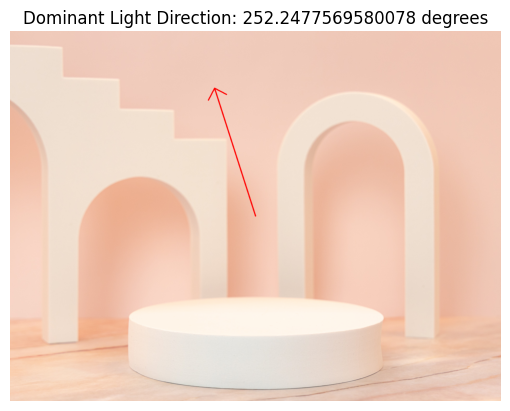

In [4]:
def estimate_illumination_direction(image_path):
    # 이미지를 그레이스케일로 불러오기
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    print(img.shape)
    # Sobel 연산자를 사용하여 x, y 방향의 그라디언트 계산
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

    # 그라디언트의 방향과 크기 계산
    magnitude, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)

    # 가장 큰 그라디언트 크기를 가진 픽셀의 방향을 반환
    dominant_direction = angle[np.unravel_index(np.argmax(magnitude), magnitude.shape)]
    dominant_magnitude = np.max(magnitude)
    return dominant_direction, dominant_magnitude

def visualize_dominant_light_direction(image_path, dominant_light_direction, dominant_magnitude):
    # 이미지 불러오기
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR로 이미지를 불러오므로 RGB로 변환

    # 이미지의 중심을 기준으로 화살표의 시작점 설정
    center_y, center_x = img.shape[0] // 2, img.shape[1] // 2

    # 화살표의 길이 설정 (예: 이미지의 너비의 1/4)
    arrow_length = np.min(img.shape[:2]) * dominant_magnitude / 1020 * 0.7
    
    # 주어진 각도로 화살표의 끝점 계산
    end_x = center_x + arrow_length * np.cos(np.radians(360 - dominant_light_direction))
    end_y = center_y - arrow_length * np.sin(np.radians(360 - dominant_light_direction))

    # 화살표 그리기
    img_with_arrow = cv2.arrowedLine(img, (center_x, center_y), (int(end_x), int(end_y)), (255, 0, 0), 3)

    # 결과 표시
    plt.imshow(img_with_arrow)
    plt.title(f"Dominant Light Direction: {dominant_light_direction} degrees")
    plt.axis('off')
    plt.show()



# image_path = "/media/mlfavorfit/sdb/template/90/25.jpg"
image_path = "/media/mlfavorfit/sdb/template/180/1071.jpg"
dominant_light_direction, dominant_magnitude = estimate_illumination_direction(image_path)
print(f"Dominant Light Direction (in degrees): {dominant_light_direction}, Magnitude:{dominant_magnitude}")

visualize_dominant_light_direction(image_path, dominant_light_direction, dominant_magnitude)


이미지 패딩 및 크롭

In [5]:
def padding_img_mask(template_arr_shape, img_arr, object_mask):
    iy, ix, _ = img_arr.shape
    ty, tx, _ = template_arr_shape

    if iy > ix:
        ratio = ty / iy
        len_y = ty
        len_x = ix * ratio
    else:
        ratio = tx / ix
        len_y = iy * ratio
        len_x = tx
    
    len_y = int(len_y); len_x = int(len_x)

    img_arr = cv2.resize(img_arr, [len_x, len_y])
    object_mask = cv2.resize(object_mask, [len_x, len_y])

    top = bottom = int((ty - img_arr.shape[0])/2)
    left = right = int((tx - img_arr.shape[1])/2)

    # 한 픽셀의 오차를 보정
    if (len_y + top + bottom) != ty:
        top += 1
    if (len_x + left + right) != tx:
        right += 1

    padded_img = cv2.copyMakeBorder(img_arr, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    padded_object_mask = cv2.copyMakeBorder(object_mask, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_img, padded_object_mask

def get_crop_mask(object_mask):
    _, binary_mask = cv2.threshold(object_mask[:,:,0], 0, 1, cv2.THRESH_OTSU)

    y, x = np.where(binary_mask == 1)
    
    # 바운딩 박스 계산
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    
    # 마스크 크롭
    cropped_mask = object_mask[y_min:y_max+1, x_min:x_max+1,:]

    return cropped_mask

광원 세기 방향 함수, 시각화 관련 함수

In [6]:
def get_light_degree_and_magnitude(img):
    # Sobel 연산자를 사용하여 x, y 방향의 그라디언트 계산
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

    # 그라디언트의 방향과 크기 계산
    magnitude, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)

    # 가장 큰 그라디언트 크기를 가진 픽셀의 방향을 반환
    dominant_direction = angle[np.unravel_index(np.argmax(magnitude), magnitude.shape)]
    dominant_magnitude = np.max(magnitude)
    return dominant_direction, dominant_magnitude

def overlay_mask(img, background, mask):
    return ((1-mask/255)*background + img*(mask/255)).astype(np.uint8)

def overlay_mask_shadow(img, background, mask, shadow):
    background = ((1-shadow/255)*background + np.zeros(img.shape)*(shadow/255))
    return ((1-mask/255)*background + img*(mask/255)).astype(np.uint8)

def visualize_one_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.namedWindow("temp", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("temp",800,800)
    cv2.imshow("temp", img)
    cv2.waitKey(0)
    cv2.destroyWindow("temp")

이미지 중앙값 가져오기

In [7]:
def get_bottom_center(object_mask):
    _, binary_mask = cv2.threshold(object_mask[:,:,0], 0, 1, cv2.THRESH_OTSU)
    for row in range(binary_mask.shape[0]-1, 0, -1):
        if np.sum(binary_mask[row]) != 0:
            obj_pixel = np.where(binary_mask[row]==1)[0]
            return (row-50, int((obj_pixel[0] + obj_pixel[-1])/2))
    return (None, None)

그림자 생성 및 blur

In [35]:
def custom_func(x):
    if x > 1200:
        x = 1200
    elif x < 200:
        x = 200
    return -0.00027*(x - 700) + (0.3 + 0.03)/2
    return -0.00018*x + 0.236
    return -0.000135*x + 0.177
    return -0.00009*x + 0.118

In [29]:
def create_shadow_topdown(mask, magnitude, degree):
    # 변환 행렬 계산
    shadow_dx = 1/magnitude * (10*mask.shape[1]) * np.cos(np.radians(degree))
    shadow_dy = 1/magnitude * (10*mask.shape[0]) * np.sin(np.radians(degree))

    M = np.float32([[1, 0, shadow_dx], [0, 1, shadow_dy]])
    
    # 선형 변환을 사용하여 그림자 생성
    shadow = cv2.warpAffine(mask, M, (mask.shape[1], mask.shape[0]))
    shadow = apply_gaussian_blur(shadow, magnitude)
    return shadow

# def custom_func(x):
#         if x > 1200:
#             x = 1200
#         elif x < 200:
#             x = 200
#         return -0.00027*(x - 700) + (0.3 + 0.03)/2

def create_shadow_onfloor(mask, magnitude, degree):
    
    cropped_mask = get_crop_mask(mask)
    bottom_center_crop = get_bottom_center(cropped_mask)
    bottom_center = get_bottom_center(mask)

    # 이동할 거리 계산
    cdy = bottom_center_crop[0]
    cdx = bottom_center_crop[1]

    dy = bottom_center[0]
    dx = bottom_center[1]

    # 중심을 원점으로 이동하는 변환 행렬
    translation_matrix = np.float32([
        [1, 0, -cdx],
        [0, 1, -cdy],
        [0, 0, 1]
    ])

    # 중심을 원래 위치로 되돌리는 변환 행렬
    inv_translation_matrix = np.float32([
        [1, 0, dx],
        [0, 1, dy],
        [0, 0, 1]
    ])

    tilt = - 1/180 * np.abs(degree-180) + 0.5
    y_scale = custom_func(magnitude)

    transform_marix = np.float32([[1,tilt,0],[0,y_scale,0],[0,0,1]])

    M = np.dot(inv_translation_matrix, np.dot(transform_marix, translation_matrix))[:2, :]
    # 선형 변환을 사용하여 그림자 생성
    shadow = cv2.warpAffine(cropped_mask, M, (mask.shape[1], mask.shape[0]))
    shadow = apply_gaussian_blur(shadow, magnitude)

    return shadow

def apply_gaussian_blur(img, magnitude):

    ratio = 0.03/500 * (700 - magnitude) + 0.05
    kernel_size = int(min(img.shape[:2]) * ratio)

    if kernel_size % 2 == 0:
        kernel_size += 1

    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    return img

RUN

In [30]:
def shadow_process(object_path, template_path):
    target_image = object_path
    template_imgae = template_path

    img_pil = Image.open(target_image)
    img_arr = np.array(img_pil)

    template_pil = Image.open(template_imgae)
    template_arr = np.array(template_pil)

    remover = Remover(fast=True, device="cuda")
    object_mask = remover.process(img_pil, type="map")

    padded_img, padded_object_mask = padding_img_mask(template_arr.shape, img_arr, object_mask)
    object_mask = padded_object_mask
    img_arr = padded_img

    background = template_arr

    degree, mag = get_light_degree_and_magnitude(template_arr)
    
    shadow_topdown = create_shadow_topdown(object_mask, mag, degree)
    shadow_onfloor = create_shadow_onfloor(object_mask, mag, degree)

    return overlay_mask_shadow(img_arr, background, object_mask, shadow_topdown), overlay_mask_shadow(img_arr, background, object_mask, shadow_onfloor), degree, mag

In [31]:
def vis_img_plot(imgs, degree, mag):
    
    fig, axes = plt.subplots(1,2, figsize=(10,10))
    titles = [f"Topdown(90 degree)\ndegree: {degree:.2f}, magnitude: {mag:.2f}", f"Floor(180 degree)\ndegree: {degree:.2f}, magnitude: {mag:.2f}"]
    for i, ax in enumerate(axes):
        ax.imshow(imgs[i])
        ax.axis('off')
        ax.set_title(titles[i])

    plt.show

In [32]:
def vis_img_plot_many(object_path_list, template_path_list):
    for i, object_path in enumerate(object_path_list):
        template_path = template_path_list[i]
        topdown_img, floor_img, degree, mag = shadow_process(object_path, template_path)
        
        vis_img_plot([topdown_img, floor_img], degree, mag)

In [33]:
object_path = ["./img/cola.jpg",
               "./img/note.jpg",
               "./img/temp.jpg",
               "./img/bike.jpg"]

template_path = ["/media/mlfavorfit/sdb/template/90/25.jpg",
                 "./img/template_90.jpg",
                 "/media/mlfavorfit/sdb/template/180/1039.jpg",
                 "./img/template_180.jpg"]

Settings -> Mode=fast, Device=cuda, Torchscript=disabled
Settings -> Mode=fast, Device=cuda, Torchscript=disabled
Settings -> Mode=fast, Device=cuda, Torchscript=disabled
Settings -> Mode=fast, Device=cuda, Torchscript=disabled


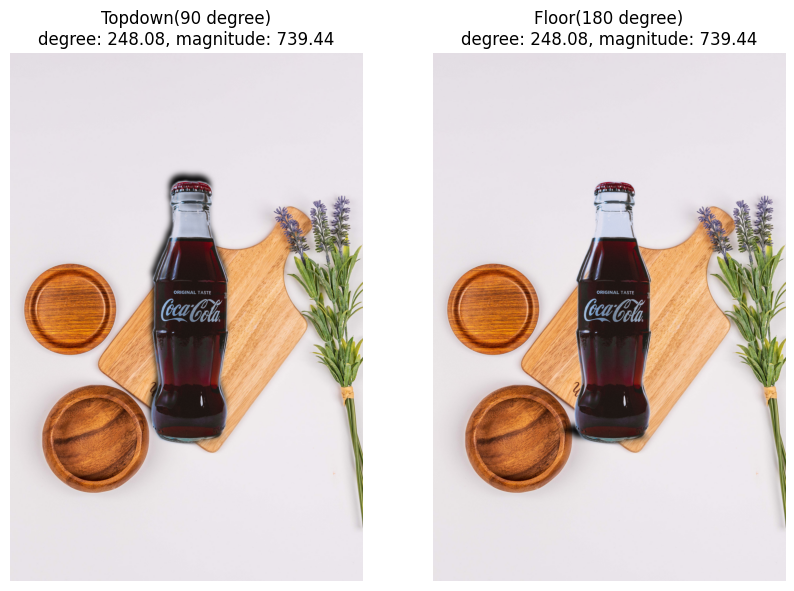

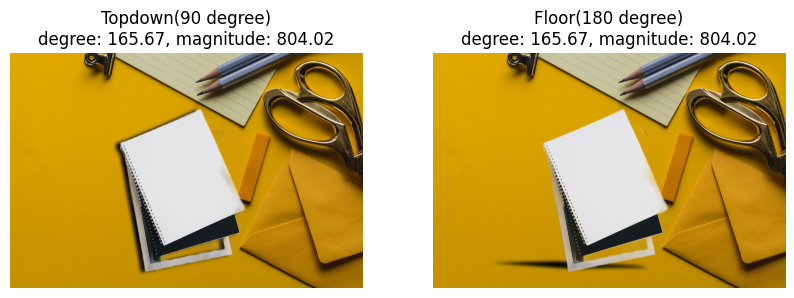

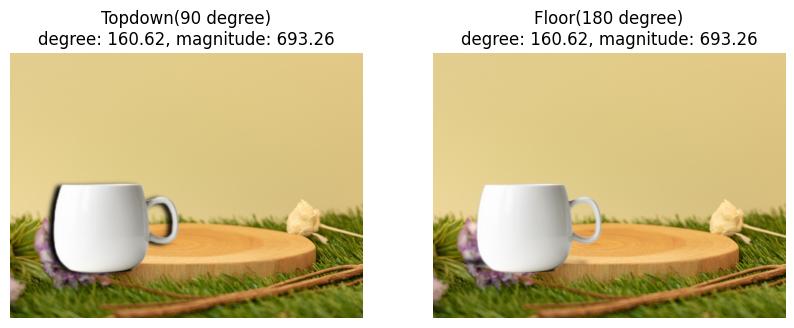

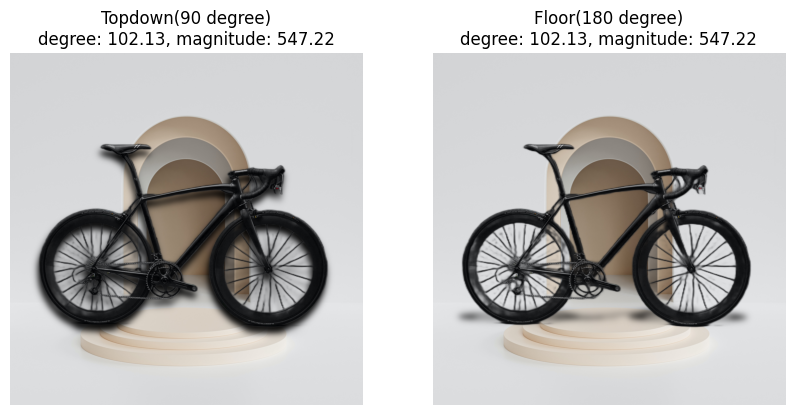

In [36]:
vis_img_plot_many(object_path, template_path)

Settings -> Mode=fast, Device=cuda, Torchscript=disabled
Settings -> Mode=fast, Device=cuda, Torchscript=disabled
Settings -> Mode=fast, Device=cuda, Torchscript=disabled
Settings -> Mode=fast, Device=cuda, Torchscript=disabled


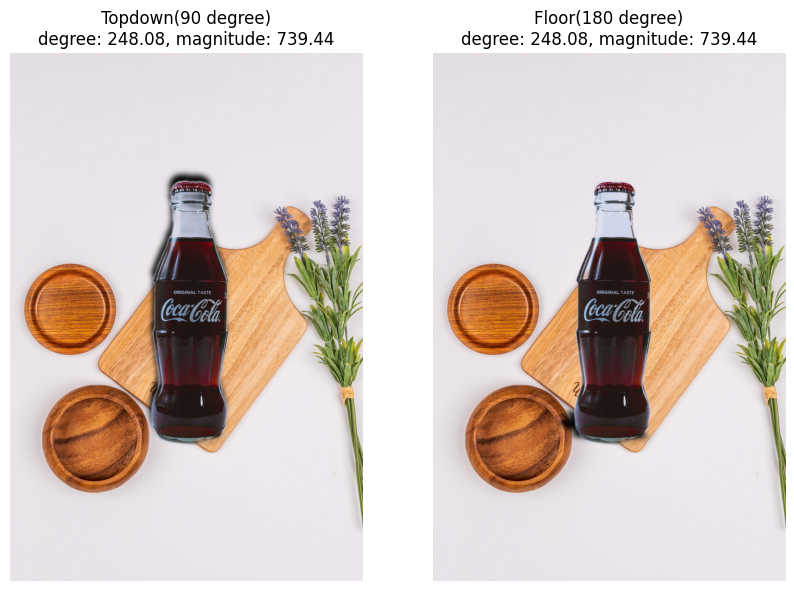

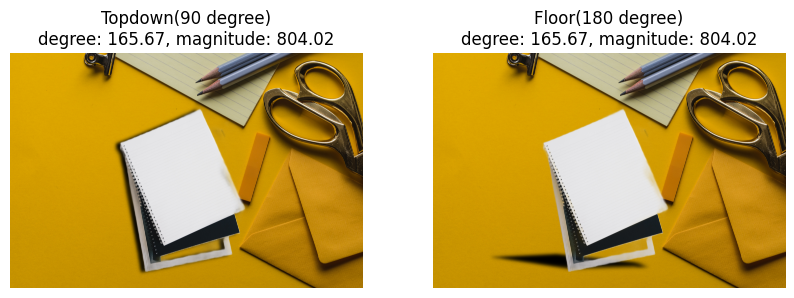

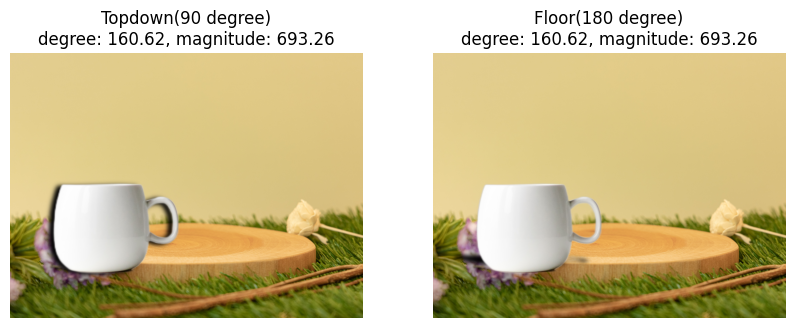

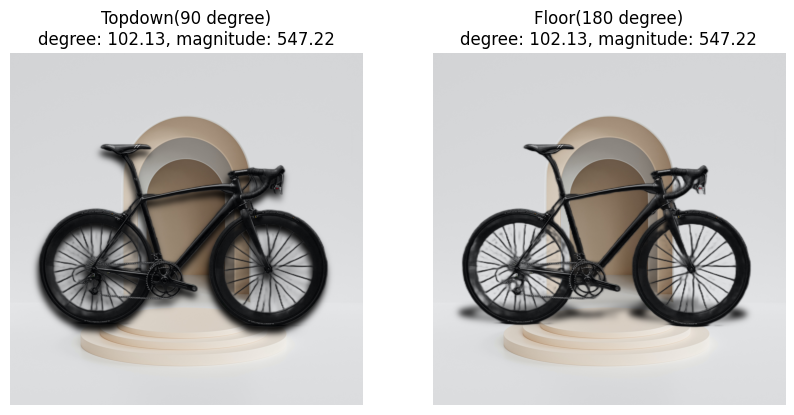

In [37]:
def custom_func(x):
    if x > 1200:
        x = 1200
    elif x < 200:
        x = 200
    # return -0.00027*(x - 700) + (0.3 + 0.03)/2
    return -0.00018*x + 0.236
    return -0.000135*x + 0.177
    return -0.00009*x + 0.118
vis_img_plot_many(object_path, template_path)

Settings -> Mode=fast, Device=cuda, Torchscript=disabled
Settings -> Mode=fast, Device=cuda, Torchscript=disabled
Settings -> Mode=fast, Device=cuda, Torchscript=disabled
Settings -> Mode=fast, Device=cuda, Torchscript=disabled


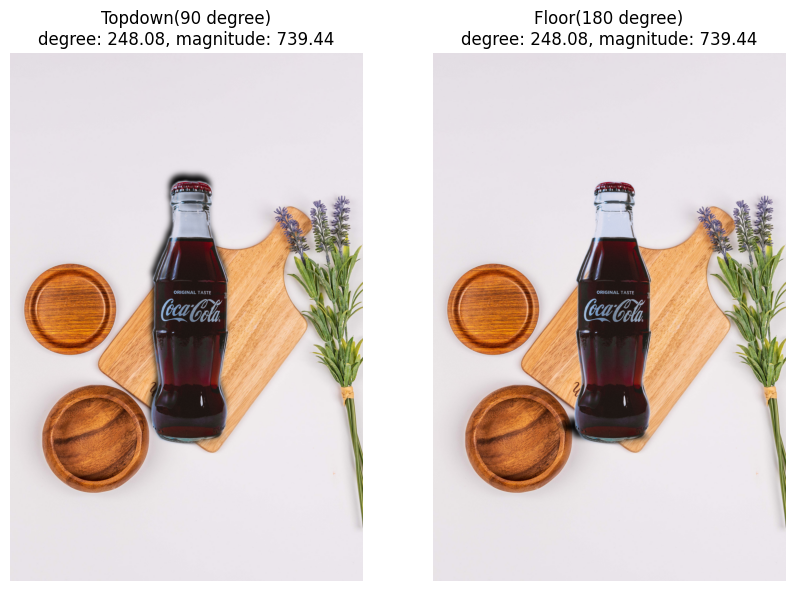

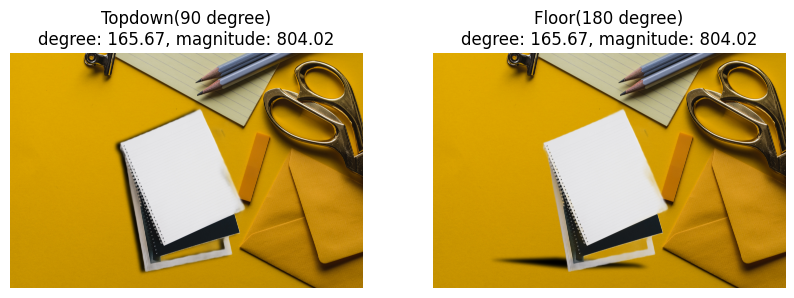

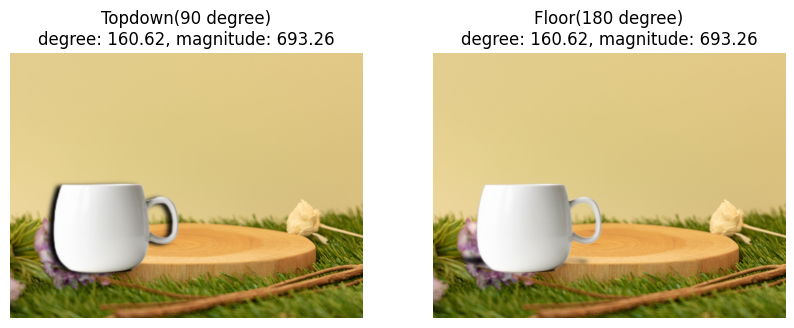

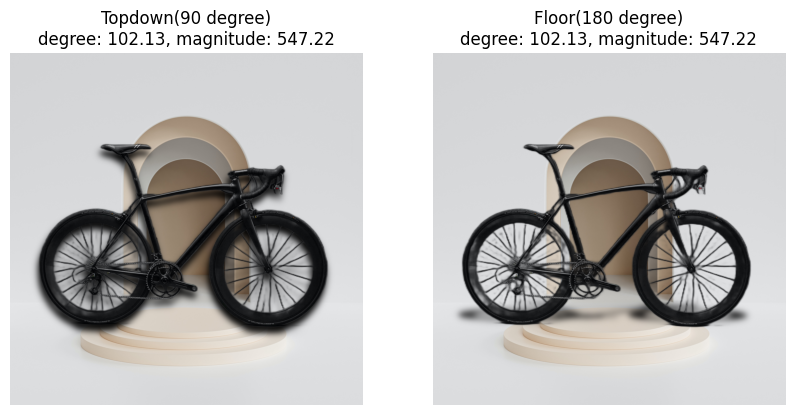

In [38]:
def custom_func(x):
    if x > 1200:
        x = 1200
    elif x < 200:
        x = 200
    # return -0.00027*(x - 700) + (0.3 + 0.03)/2
    # return -0.00018*x + 0.236
    return -0.000135*x + 0.177
    return -0.00009*x + 0.118
vis_img_plot_many(object_path, template_path)

Settings -> Mode=fast, Device=cuda, Torchscript=disabled
Settings -> Mode=fast, Device=cuda, Torchscript=disabled
Settings -> Mode=fast, Device=cuda, Torchscript=disabled
Settings -> Mode=fast, Device=cuda, Torchscript=disabled


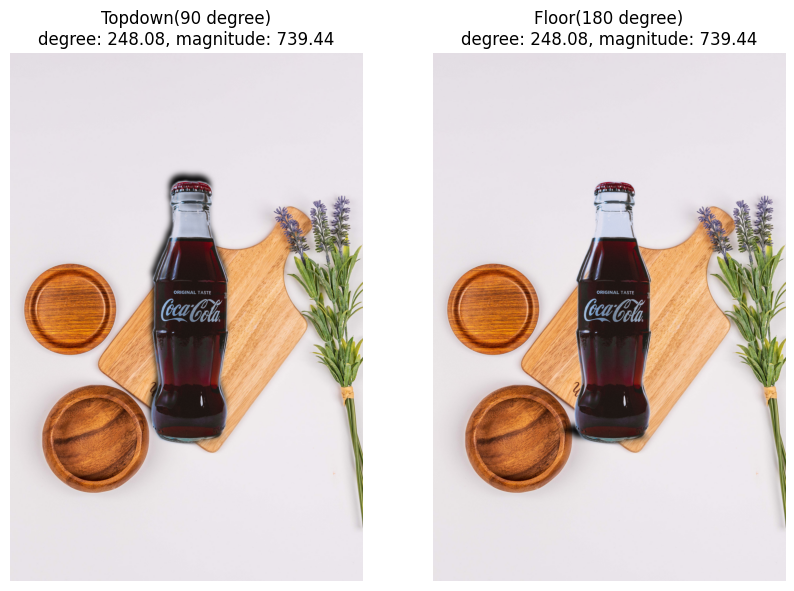

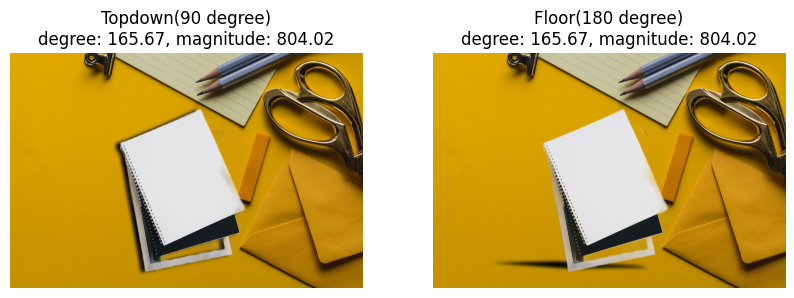

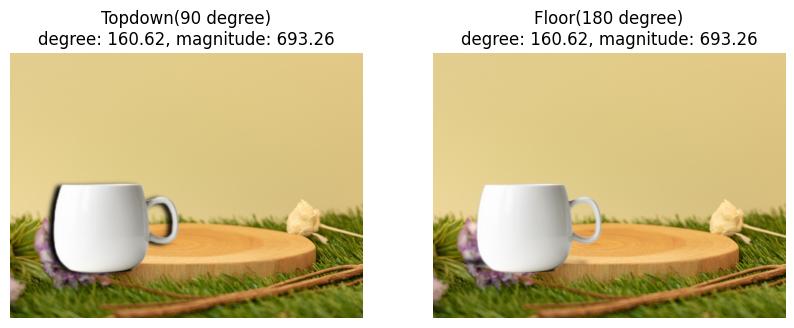

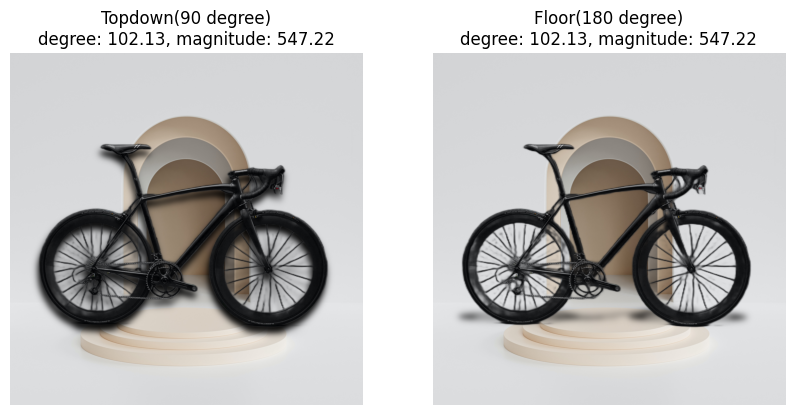

In [39]:
def custom_func(x):
    if x > 1200:
        x = 1200
    elif x < 200:
        x = 200
    # return -0.00027*(x - 700) + (0.3 + 0.03)/2
    # return -0.00018*x + 0.236
    # return -0.000135*x + 0.177
    return -0.00009*x + 0.118
vis_img_plot_many(object_path, template_path)

---

.py파일 클래스로 정의

In [122]:
import numpy as np
import cv2
import base64
from io import BytesIO

def bs64_to_arr(bs64_str):
    decoded_bytes = base64.b64decode(bs64_str)
    buffer = BytesIO(decoded_bytes)
    img_arr = cv2.imdecode(np.frombuffer(buffer.getvalue(), dtype=np.uint8), cv2.IMREAD_COLOR)
    return img_arr

def arr_to_bs64(img_arr):
    _, buffer = cv2.imencode('.jpg', img_arr)
    bs64_str = base64.b64encode(buffer).decode('utf-8')
    return bs64_str

def custom_func(x):
    if x > 1200:
        x = 1200
    elif x < 200:
        x = 200
    return -0.00027*(x - 700) + (0.3 + 0.03)/2

def apply_gaussian_blur(img, magnitude):

    ratio = 0.03/500 * (700 - magnitude) + 0.05
    kernel_size = int(min(img.shape[:2]) * ratio)

    if kernel_size % 2 == 0:
        kernel_size += 1

    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    return img


class ShadowMaker:
    def __init__(self):
        pass
    

    def extract_light_degree_and_magnitude(self, img_arr):
        img = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)

        # Sobel 연산자를 사용하여 x, y 방향의 그라디언트 계산
        grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

        # 그라디언트의 방향과 크기 계산
        magnitude, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)

        # 가장 큰 그라디언트 크기를 가진 픽셀의 방향을 반환
        degree = angle[np.unravel_index(np.argmax(magnitude), magnitude.shape)]
        magnitude = np.max(magnitude)

        return degree, magnitude
    

    def get_bottom_center(self, shadow_arr):
        _, binary_mask = cv2.threshold(shadow_arr[:,:,0], 0, 1, cv2.THRESH_OTSU)
        for row in range(binary_mask.shape[0]-1, 0, -1):
            if np.sum(binary_mask[row]) != 0:
                obj_pixel = np.where(binary_mask[row]==1)[0]
                return (row-10, int((obj_pixel[0] + obj_pixel[-1])/2))
        return (None, None)
    

    def linear_transform_topdown(self, shadow_arr, degree, magnitude):

        # 변환 행렬 계산
        shadow_dx = 1/(10*shadow_arr.shape[0]) * np.cos(np.radians(degree))
        shadow_dy = 1/(10*shadow_arr.shape[1]) * np.sin(np.radians(degree))

        M = np.float32([[1, 0, shadow_dx], [0, 1, shadow_dy]])
        
        # 선형 변환을 사용하여 그림자 생성
        shadow_arr = cv2.warpAffine(shadow_arr, M, (shadow_arr.shape[1], shadow_arr.shape[0]))

        return shadow_arr, M
    

    def get_crop_mask(self, object_mask):
        _, binary_mask = cv2.threshold(object_mask[:,:,0], 0, 1, cv2.THRESH_OTSU)

        y, x = np.where(binary_mask == 1)
        
        # 바운딩 박스 계산
        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)
        
        # 마스크 크롭
        cropped_mask = object_mask[y_min:y_max+1, x_min:x_max+1,:]

        return cropped_mask
    

    def linear_transform_floor(self, shadow_arr, degree, magnitude):
    
        cropped_mask = self.get_crop_mask(shadow_arr)
        c_y_crop, c_x_crop = self.get_bottom_center(cropped_mask)
        c_y, c_x = self.get_bottom_center(shadow_arr)

        # 중심을 원점으로 이동하는 변환 행렬
        translation_matrix = np.float32([
            [1, 0, -c_x_crop],
            [0, 1, -c_y_crop],
            [0, 0, 1]
        ])

        # 중심을 원래 위치로 되돌리는 변환 행렬
        inv_translation_matrix = np.float32([
            [1, 0, c_x],
            [0, 1, c_y],
            [0, 0, 1]
        ])

        tilt = - 1/180 * np.abs(degree-180) + 0.5
        y_scale = custom_func(magnitude)

        transform_marix = np.float32([[1,tilt,0],[0,y_scale,0],[0,0,1]])
        M = np.dot(inv_translation_matrix, np.dot(transform_marix, translation_matrix))[:2, :]

        # 선형 변환을 사용하여 그림자 생성
        shadow_arr = cv2.warpAffine(cropped_mask, M, (shadow_arr.shape[1], shadow_arr.shape[0]))

        return shadow_arr, M


    def get_blur_value(self, magnitude):
        if magnitude > 1500:
            magnitude = 1500
        elif magnitude < 300:
            magnitude = 300
        return -0.06*magnitude + 118


    def get_transparency_value(self, magnitude):
        if magnitude > 1500:
            magnitude = 1500
        elif magnitude < 300:
            magnitude = 300
        return 0.075*magnitude - 12.5

    def mask_2_blackobj(self, mask_img):

        h, w = mask_img.shape[:2]
        black_obj = np.zeros((h, w, 4), dtype=mask_img.dtype)

        black_obj[:,:,3] = mask_img[:,:,0]
 
        return black_obj


    def process(self, template_arr, shadow_arr, angle="topdown"):
        degree, magnitude = self.extract_light_degree_and_magnitude(template_arr)
        
        if angle == "topdown":
            shadow_arr, M = self.linear_transform_topdown(shadow_arr, degree, magnitude)
        elif angle == "floor":
            shadow_arr, M = self.linear_transform_floor(shadow_arr, degree, magnitude)

        blur_value = self.get_blur_value(magnitude)
        transparency_value = self.get_transparency_value(magnitude)

        black_shadow_png = self.mask_2_blackobj(shadow_arr)

        bs64_shadow = arr_to_bs64(black_shadow_png)

        return {"shadow":black_shadow_png, "blur":blur_value, "opacity":transparency_value, "matrix":M} # test code
        # return {"shadow":bs64_shadow, "blur":blur_value, "opacity":transparency_value, "matrix":M}
    

# if __name__ == "__main__":
#     shadow_img_arr = None
#     template_img_arr = None

#     shadowmaker = ShadowMaker()

#     '''
#     result json key: 
#         shadow = base64 image, blur = blur value(0~100), 
#         opacity = transparency value(0~100), M = lenear transform matrix(Affine)
#     '''

#     result_json = shadowmaker.process(template_img_arr, shadow_img_arr, angle="topdown")
#     # result_json = shadowmaker.process(template_img_arr, shadow_img_arr, angle="floor")

클래스 사용법

In [118]:
from transparent_background import Remover
from PIL import Image

object_pil = Image.open("./img/small.jpg")
remover = Remover(fast=True, device="cuda")
object_mask = remover.process(object_pil, type="map")

img_arr = cv2.imread("/media/mlfavorfit/sdb/template/90/25.jpg")
shadow_arr = object_mask

shadowmaker = ShadowMaker()
shadow = shadowmaker.process(img_arr, shadow_arr, angle="topdown")["shadow"]

print(shadow_arr.shape)
print(shadow.shape)

cv2.imwrite("output.png", shadow)

Settings -> Mode=fast, Device=cuda, Torchscript=disabled


In [42]:
from transparent_background import Remover
from PIL import Image

object_pil = Image.open("./img/small.jpg")
remover = Remover(fast=True, device="cuda")
object_mask = remover.process(object_pil, type="rgba")

Image.fromarray(object_mask).save("output2.png")

Settings -> Mode=fast, Device=cuda, Torchscript=disabled


In [2]:
from PIL import Image

object_pil = Image.open("./img/cola.jpg")

In [5]:
object_pil.resize([512,512]).save("resized_cola.jpg")